<a href="https://colab.research.google.com/github/ikarteeva/NLPMosRu/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Competition_Mosru%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выделение актуальных проблем Москвы в обращениях москвичей для соревнования на Codalab

##Установка необходимых компонент, импорт библиотек и данных

In [ ]:
!wget https://github.com/buriy/spacy-ru/releases/download/v2.3_beta/ru2_combined_400ks_96.zip
!unzip ru2_combined_400ks_96.zip
!pip install pymorphy2
!pip install spacy==2.3 
!pip install geopandas
!wget http://gis-lab.info/data/mos-adm/mo-shape.zip
!unzip mo-shape.zip

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from random import randint
import copy

from google.colab import drive
drive.mount('/content/drive/')

import spacy
import re
import networkx as nx
from spacy import displacy
import tqdm
import re 
from scipy import sparse
import pickle
from sklearn.decomposition import LatentDirichletAllocation
from itertools import product
import geopandas as gpd

Mounted at /content/drive/


In [ ]:
#Получение данных
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n1ax53On1A3B6EpFmGTms8YoofrE7NMy'  -O Mosru_dump_all_pages.txt

## Препроцессинг

In [ ]:
# Загружаем тексты
fname= 'Mosru_dump_all_pages.txt'
with open(fname, 'r', encoding= 'utf8') as f:
    all_lines= f.readlines()

In [ ]:
nlp = spacy.load("ru2_combined_400ks_96")
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

##Функции для обработки текста


In [ ]:
def get_nsubj(doc):  
  keyphrases= []
  for token in doc:    
    keyphrase= ''
    if 'nsubj' in token.dep_:    
      for t in token.subtree:
        keyphrase+= t.text+ ' '
      keyphrases.append(keyphrase)

  return(keyphrases)

def get_amod(doc):
  keyphrases= [] 
  for token in doc:   
    
    if 'amod' in token.dep_:           
        keyphrases.append(token.text+ ' ' +  token.head.text)
      

  return(keyphrases)

def get_xcomp(doc):
  keyphrases= [] 
  for token in doc:   
    
    if 'xcomp' in token.dep_:           
        keyphrases.append(token.text+ ' ' +  token.head.text)
      

  return(keyphrases)

In [ ]:
def get_area(area_raw): 
  area_raw= area_raw.replace('ё', 'е')
  area=''
  
  area1=re.findall('(?<=управы )(.*)(?= района)', area_raw)
  if area1:
    area=area1

  area1=re.findall('(?<=района)(.*)(?=города)', area_raw) 
  if area1:
    area=area1

  area1=re.findall('(?<=управы района )(.*)(?=)', area_raw) 
  if area1:
    area=area1

  area1= re.findall('(?<=главы управы )(.*)(?=)', area_raw)
  if area1:
    area=area1

  area1= re.findall('(?<=Глава управы )(.*)(?=)', area_raw) 
  if area1:
    area=area1

  area1 = re.findall('(?<=ГБУ "Жилищник района )(.*)(?=")', area_raw)
  if area1:
    area=area1

  area1 = re.findall('(?<=ГБУ "Жилищник )(.*)(?=района")', area_raw)
  if area1:
    area=area1

  area1 = re.findall('(?<=«Жилищник района)(.*)(?=»)', area_raw)
  if area1:
    area=area1

  area1 = re.findall('(?<=ГБУ «Жилищник )(.*)(?=района»)', area_raw)
  if area1:
    area=area1

  area1 = re.findall('(?<=района ")(.*)(?=")', area_raw)
  if area1:
    area=area1

  area1 = re.findall('(?<=ГБУ "Жилищник Жулебино района )(.*)(?=")', area_raw)
  if area1:
    area=area1
    
  area1 = re.findall('(?<=управы, Управа )(.*)(?=)', area_raw)
  if area1:
    area=area1

  if area:  
    area= area[0].strip()
    if 'ного' in area:
      area=area.replace('ного','ный')
    if 'кого' in area:
      area=area.replace('кого','кий')

    return(area)

  else:
    return('')

area_raw= all_lines[112].split("', '")[3]
print(area_raw)
get_area(area_raw)

 глава управы района Сокол города Москвы


'Сокол города Москвы'

In [ ]:
def get_street(street_raw):
  
  pattern= '''((?<=по адресу)(.*)(?=д.))|(?<=по адресу)(.*)(?=вл.)|(?<=по адресу)(.*)(?=с.)|(?<=по адресу)(.*)(?!=[(д.)(с.)(вл.)(зд.)])'''  
  street= re.findall(pattern, street_raw)
  if street:
    street= [t for t in street[0] if len(t)>0][0].strip()
    return(street)
  else:
    return('')
  
street_raw= all_lines[310].split("', '")[0]
get_street(street_raw)

'улица Госпитальный Вал'

In [ ]:
# Сопоставление улицы и района. 

street_2_area_dict= dict({})
streets= [None for street in all_lines]

for j,message in enumerate(all_lines):
  street_raw= message.split("', '")[0]
  street= get_street(street_raw)
  area_raw= message.split("', '")[3] 
  area= get_area(area_raw)
  if street and area:
    street_2_area_dict[street]= area
  if street:
    streets[j]= street

In [ ]:
keyphrases_per_area= dict([(area,[]) for area in street_2_area_dict.values()])
success_cnt= 0 

for ind in tqdm.tqdm(range(len(all_lines))):   
  street= streets[ind]
  area= street_2_area_dict.get(street, None)
  if street and area:
    text= all_lines[ind].split("', '")[1]

    doc= nlp(text)
    if len([t for t in doc])<=4:
      keyphrases_per_area[area].append(text)
      success_cnt+=1
    else:
      keyphrase_nsubj= get_nsubj(doc)
      keyphrase_amod= get_amod(doc)
      keyphrase_xcomp= get_xcomp(doc)
      
      if len(keyphrase_nsubj)!=0 :
        keyphrases_per_area[area]+=keyphrase_nsubj
        
      if len(keyphrase_amod)!=0:      
        keyphrases_per_area[area]+=keyphrase_amod

      if len(keyphrase_xcomp)!=0:      
        keyphrases_per_area[area]+=keyphrase_xcomp

      if len(keyphrase_nsubj)!=0 or len(keyphrase_amod)!=0 or len(keyphrase_xcomp)!=0:
        success_cnt+=1

print('{:2.2f}% сообщений успешно проверено'.format(100*success_cnt/len(all_lines)))
print(keyphrases_per_area[area])

In [ ]:
#сохраняем данные для ускорения обработки в дальнейшем
with open('/content/drive/MyDrive/keyphrases_per_area_lemmatized.p','wb') as f:
  pickle.dump(keyphrases_per_area, f)  

In [ ]:
print(keyphrases_per_area[area])

##Лемматизация и обработка текста

In [ ]:
#функция лемматизации

import re
import nltk
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

nltk.download('stopwords')

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and len(token)>3:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
        print(tokens)
    return None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
for area, phrases in tqdm.tqdm(keyphrases_per_area.items()):
  phrases_lemmatized= []
  phraseString = ' '.join(keyphrases_per_area[area])
  lemmatize_text = lemmatize(phraseString)
  if lemmatize_text:
    print(lemmatize_text)
    phrases_lemmatized.append(lemmatize_text) 
keyphrases_per_area[area]= phrases_lemmatized 

In [ ]:
print(area, keyphrases_per_area[area])

Новокосино города Москвы [['больший', 'куча', 'мусор', 'лежать', 'приблизительно', 'месяц', 'один', 'куча', 'целый', 'свалка', 'просьба', 'принять', 'мера', 'суздальский', 'больший', 'куча', 'обслуживающий', 'организация', 'целый', 'свалка', 'принять', 'просьба']]


In [ ]:
with open('/content/drive/MyDrive/keyphrases_per_area_lemmatized1.p','wb') as f:
  pickle.dump(keyphrases_per_area, f) 

In [ ]:
with open('/content/drive/MyDrive/keyphrases_per_area_lemmatized1.p','rb') as f:
  keyphrases_per_area= pickle.load(f)

In [ ]:
id=0
word_2_id_dict= dict({})
for __, phrases in keyphrases_per_area.items():
  for phrase in phrases:
    for word in phrase:
      if not word in word_2_id_dict.keys():
        word_2_id_dict[word]=id      
        id+=1

words= [w for w in word_2_id_dict.keys()]

In [ ]:
Nwords= len(words)
docID_2_area= dict({})

Ndocs= 0
for area, phrases in keyphrases_per_area.items():
  Ndocs+= len(phrases) 

doc_mtx= sparse.lil_matrix((Ndocs, Nwords)) 

doc_id= 0
for area, phrases in tqdm.tqdm(keyphrases_per_area.items()):
  for phrase in phrases:    
    for word in phrase:
      col= word_2_id_dict[word] 
      doc_mtx[doc_id,col]= 1

    docID_2_area[doc_id]= area
    doc_id+=1  

100%|██████████| 325/325 [00:21<00:00, 15.18it/s]


In [ ]:
LDA= LatentDirichletAllocation(n_components=50, topic_word_prior=.99, random_state= 0)
LDA.fit(doc_mtx)
topics= LDA.transform(doc_mtx)

##Разнообразные визуализации данных после обработки

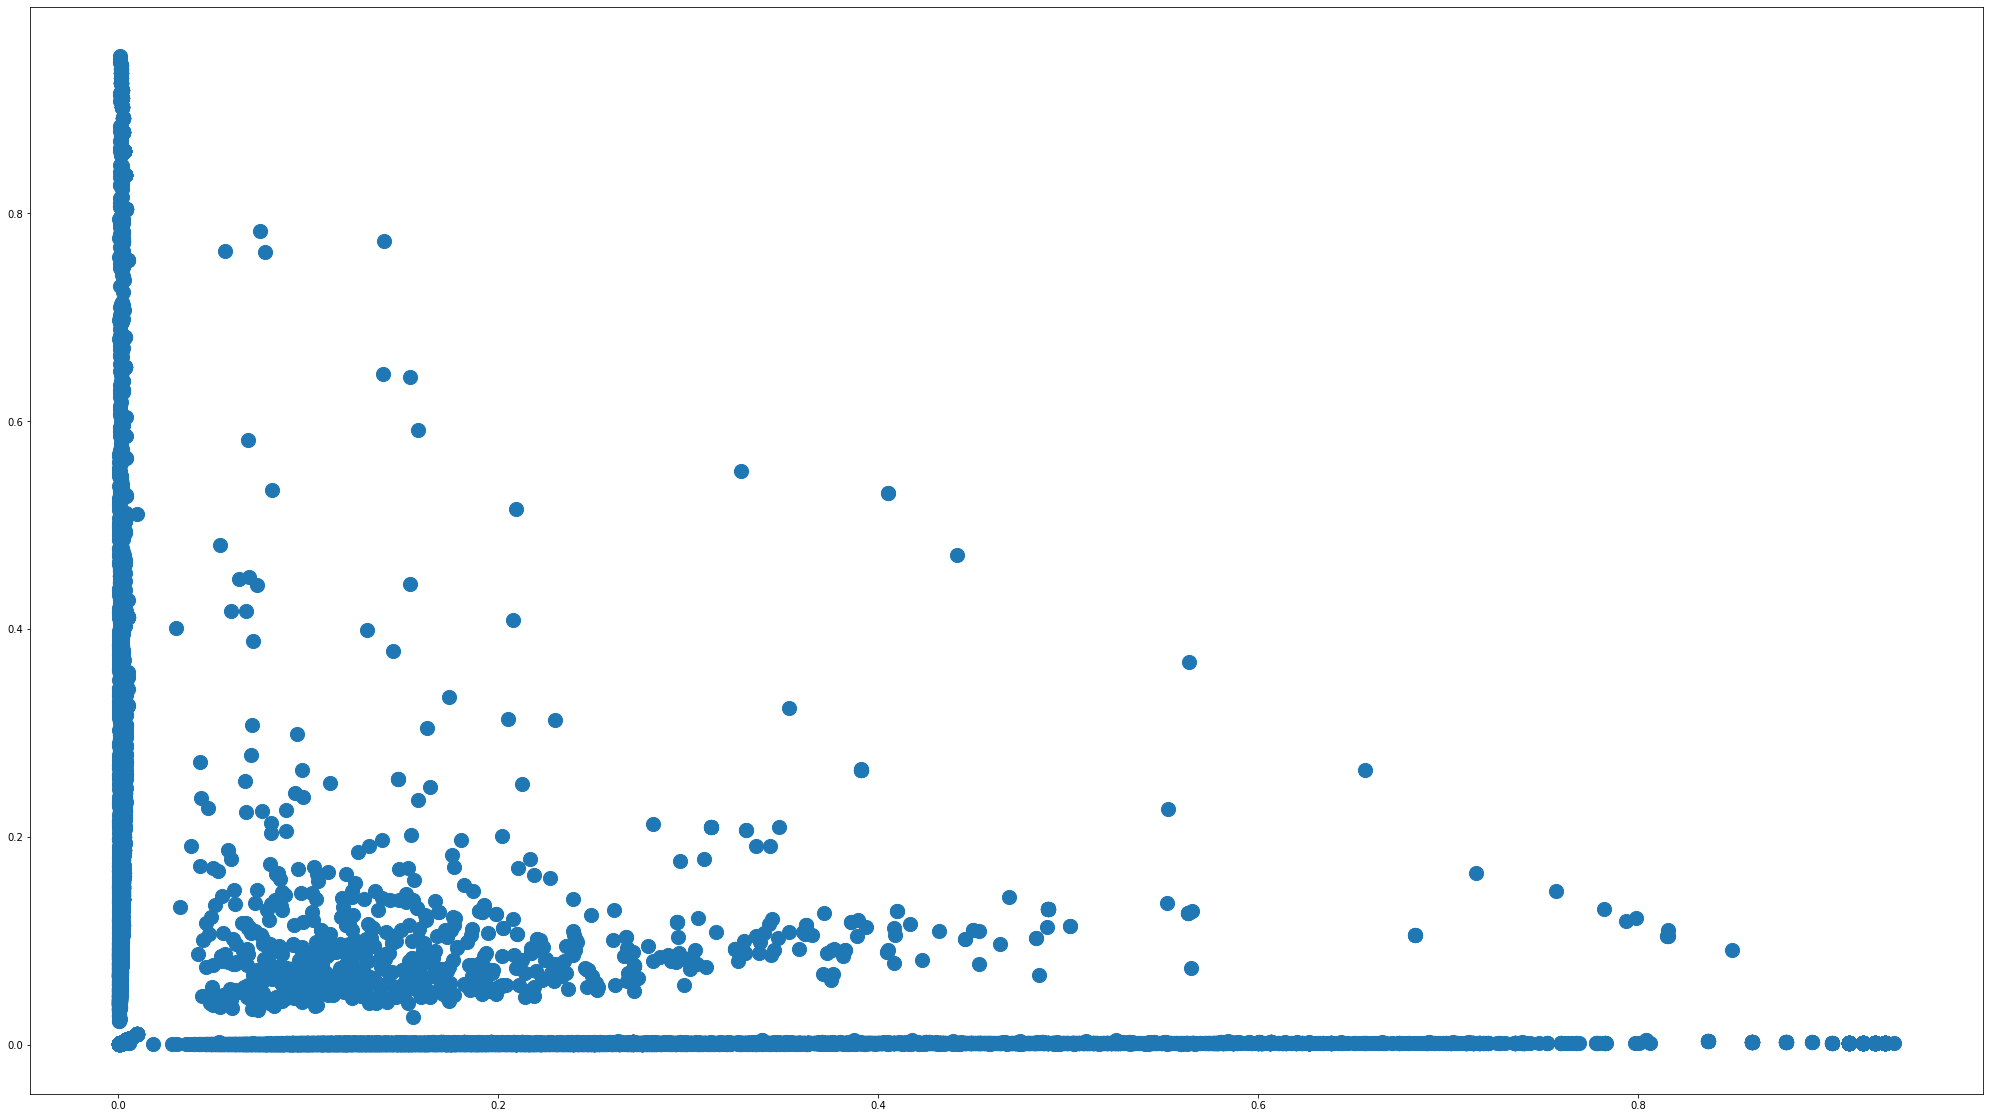

In [ ]:
plt.figure(figsize = (35, 20))
plt.scatter(topics[:, 0], topics[:, 1], s=200)

In [ ]:
Ncomponents=LDA.components_.shape[0]
N_top_words=5
for j in range(Ncomponents):
  print('topic {}:\n'.format(j))  
  for k in np.argsort(LDA.components_[j,:]):
    if(len(words[k])>5):
      print(words[k])

In [ ]:
j_topic= 41 
area2topic_prob= dict({})

for docID, area in docID_2_area.items(): 
  if not area in area2topic_prob.keys():
    area2topic_prob[area]= []
  area2topic_prob[area].append(topics[docID, j_topic])

for area in area2topic_prob.keys():
  area2topic_prob[area]= np.sum(area2topic_prob[area])/(len(area2topic_prob[area]))
  

[(area, area2topic_prob[area]) for area in sorted(area2topic_prob.keys(), key= lambda x: area2topic_prob[x], reverse= True)] 

[('Тверский', 0.46590909090909083),
 ('района Кузьминки города Москвы', 0.10179062312797611),
 ('Дорогомилово', 0.06520469707706342),
 ('района Москворечье-Сабурово', 0.044223663613899414),
 ('Нагатинский Затон', 0.0438440656481253),
 ('Северный города Москвы', 0.04292288202701985),
 ('Дорогомилово города Москвы', 0.04244110602330193),
 ('Марьино города Москвы', 0.04217773211413974),
 ('Лианозово города Москвы', 0.040487687157172374),
 ('Силино города Москвы', 0.04019818700729611),
 ('района Свиблово', 0.034474906790646506),
 ('района Ивановское', 0.034368250285020496),
 ('Ярославский района', 0.032525599555589355),
 ('Покровское-Стрешнево города Москвы', 0.03211564653559928),
 ('Вешняки города Москвы', 0.030966125607020726),
 ('Северное Бутово', 0.026791626582696626),
 ('Солнцево города Москвы', 0.02622505937855717),
 ('Аэропорт', 0.026058861481753903),
 ('Свиблово города Москвы', 0.02593495228004479),
 ('района Левобережный', 0.025381990992671893),
 ('района Восточное Измайлово', 0.0

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

##Построение карты районов

In [ ]:
# Загрузка районов
mo_gdf = gpd.read_file('mo.shp')

In [ ]:
# сопоставление названий районов из текстов mos.ru и из карты районов
mo_gdf['NAME_NORM']= mo_gdf['NAME'].apply(lambda x: x.lower().replace('ё','е')) 
mo_gdf['topic_importance']= 0.0

for j in mo_gdf.index:
  area_stemmed= mo_gdf.iloc[j]['NAME_NORM'] 
  for area in area2topic_prob.keys():
    if area_stemmed in area.lower():
      mo_gdf.loc[j,'topic_importance']= float(area2topic_prob[area])      
      break


In [ ]:
print(mo_gdf)

                 NAME     OKATO  ...         NAME_NORM topic_importance
0            Киевский  45298555  ...          киевский         0.000000
1      Филёвский Парк  45268595  ...    филевский парк         0.020106
2     Новофёдоровское  45298567  ...   новофедоровское         0.000000
3           Роговское  45298575  ...         роговское         0.000000
4        "Мосрентген"  45297568  ...      "мосрентген"         0.000000
..                ...       ...  ...               ...              ...
141        Ивановское  45263567  ...        ивановское         0.024088
142  Косино-Ухтомский  45263573  ...  косино-ухтомский         0.023284
143        Новокосино  45263579  ...        новокосино         0.009029
144        Некрасовка  45290574  ...        некрасовка         0.009830
145           Кунцево  45268562  ...           кунцево         0.009896

[146 rows x 10 columns]


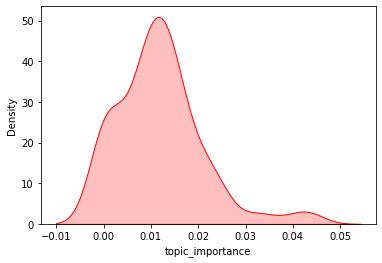

In [ ]:
snsplot = sns.kdeplot(mo_gdf['topic_importance'], legend=True, shade=True, color='red')
fig = snsplot.get_figure()

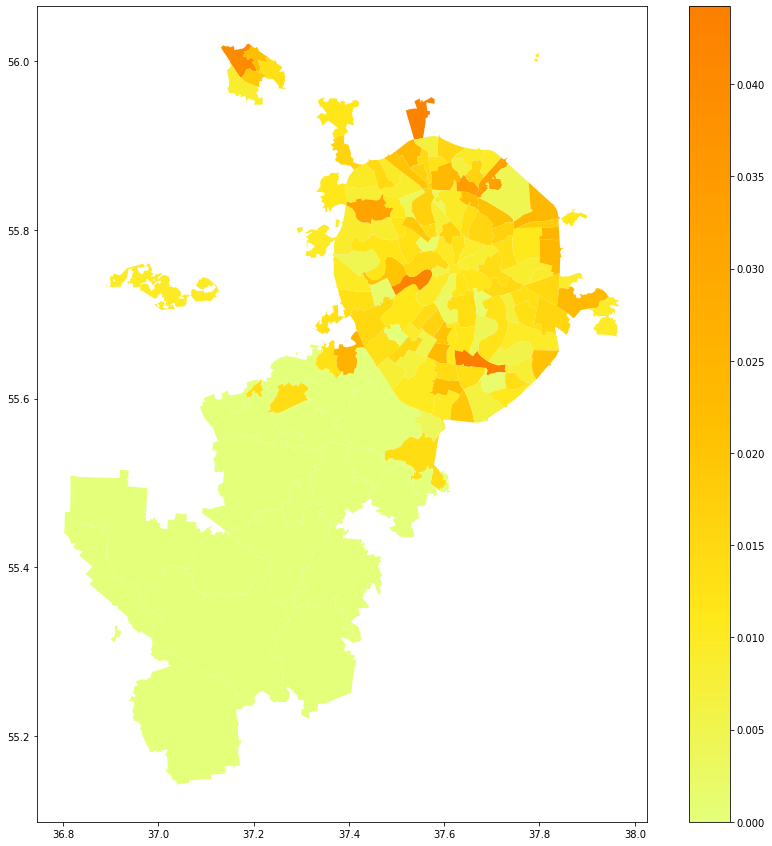

In [ ]:
mo_gdf.plot(column = 'topic_importance', linewidth=0.5, cmap='Wistia', legend= True, figsize=[15,15])